# Real/Fake Job Postings Classification

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Assignment Description:</b> 

- Dataset: The dataset used in this project was downloaded from Kaggle.com. It was provided by the university of the Aegean and contains 18,000 job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.
- : Our goal is to build four models for job postings classification and select the model with the highest accuracy, precision, scores.  </div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid green 2px; padding: 20px"> <b>Approach:</b><br>
Logistic regression, support vector machines, and tree-family work best for text classification. We will build three models, evaluate them using accuracy, precision, recall, and F1 score metrics. We will also build Precision-Recall curves to evaluate the model's performance. </div><br>

## Exploratory Data Analysis 

We import libraries and read the data.

In [6]:
# Data handling
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler

# Text preprocessing
import re
import string
import html
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Evaluation
from sklearn.metrics import (
    classification_report, precision_recall_curve, 
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Explainability
#!pip install shap
import shap
from shap.maskers import Independent

In [7]:
path='fake_job_postings.csv'
postings = pd.read_csv(path)
postings.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


Our dataset contains 18 columns and 17879 rows. Data is mostly categorical.

In [9]:
postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Many columns contain a significant number of NaN values (15% and more). It does not make sense to use these columns for classification purposes. 

In [11]:
# Total number of rows
total_rows = len(postings)

# Create the summary table
nan_summary = pd.DataFrame({
    'Missing Values': postings.isna().sum(),
    'Percentage (%)': (postings.isna().sum() / total_rows * 100).round(2)
})

# Sort descending by number of missing values (optional)
nan_summary = nan_summary.sort_values(by='Missing Values', ascending=False)

# Display
print(nan_summary)

                     Missing Values  Percentage (%)
salary_range                  15012           83.96
department                    11547           64.58
required_education             8105           45.33
benefits                       7212           40.34
required_experience            7050           39.43
function                       6455           36.10
industry                       4903           27.42
employment_type                3471           19.41
company_profile                3308           18.50
requirements                   2696           15.08
location                        346            1.94
description                       1            0.01
job_id                            0            0.00
telecommuting                     0            0.00
has_questions                     0            0.00
has_company_logo                  0            0.00
title                             0            0.00
fraudulent                        0            0.00


The next step is to drop duplicates and fill in one NaN value in the "description" column. We will keep only columns with less than 15% of NaN values. 

In [13]:
postings = postings.drop_duplicates(subset='job_id')

In [14]:
postings_new = postings[["job_id", "title", "description", "location", 
                         "telecommuting", "has_company_logo", "has_questions", 
                         "fraudulent"]].copy()

How many times does each unique value appear in the column? Let's take a look at 5 most popular values. From the break down below we can see that the dataset is highly imbalanced: there are 17014 real job postings and 866 fake.

In [16]:
columns = ["title", "location", 'telecommuting', 'has_company_logo', 'has_questions', "fraudulent"]
for e in columns:
    print(e, postings_new[columns][e].value_counts().head())

title title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64
location location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: count, dtype: int64
telecommuting telecommuting
0    17113
1      767
Name: count, dtype: int64
has_company_logo has_company_logo
1    14220
0     3660
Name: count, dtype: int64
has_questions has_questions
0    9088
1    8792
Name: count, dtype: int64
fraudulent fraudulent
0    17014
1      866
Name: count, dtype: int64


London, New York and San Francisco are the most frequent locations. English teacher and customer service associates are the most frequent job titles.

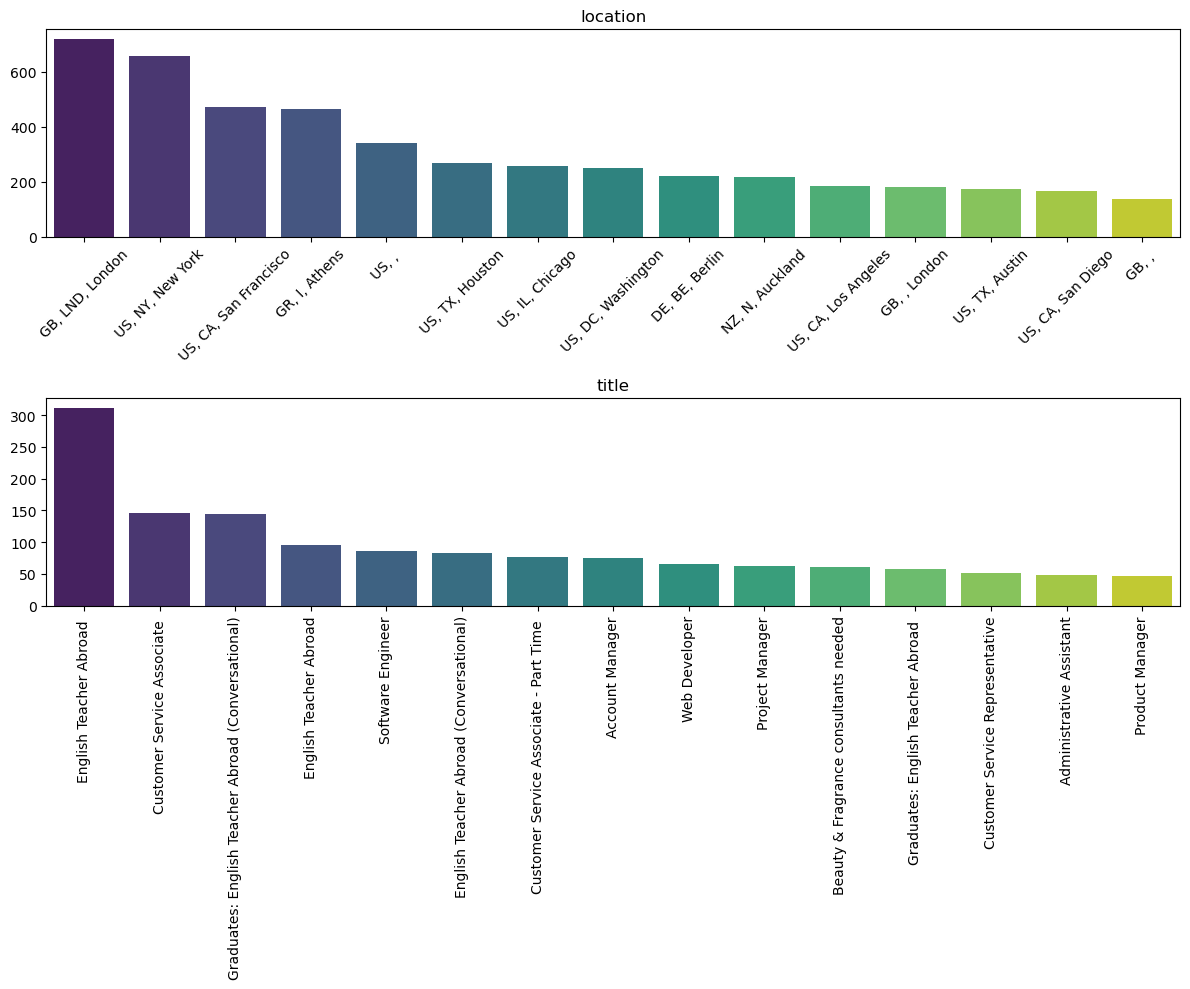

In [18]:
visualize = ['location', 'title']
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
j = 0

for col in visualize:
    ax_g = ax[j]

    top_counts = postings_new[col].value_counts().iloc[:15]
    categories = top_counts.index
    counts = top_counts.values
    bar_df = pd.DataFrame({col: categories, 'count': counts})
    palette = sns.color_palette("viridis", len(categories))
    chart = sns.barplot(
    data=bar_df,
    x=col,
    y='count',
    hue=col,        
    ax=ax_g,
    palette=palette,
    legend=False    
    )


    chart.tick_params(axis='x', rotation=90 if j == 1 else 45)
    ax_g.set_ylabel('')
    ax_g.set_xlabel('')
    ax_g.set_title(col, fontsize=12)
    j += 1

plt.tight_layout()
plt.show()

Fake job postings constitute 4.8% of the total job postings. 

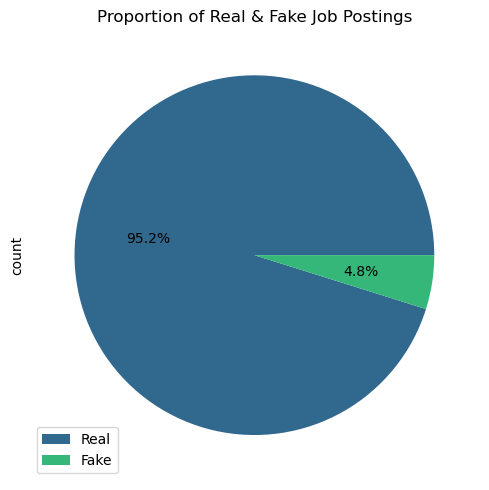

In [20]:
labels = ["Real", "Fake"]
colors = sns.color_palette("viridis", len(labels))  # or "coolwarm", "plasma", etc.
postings_new['fraudulent'].value_counts().plot.pie(
    figsize=(5, 5),
    title="Proportion of Real & Fake Job Postings",
    labels=["", ""],           
    autopct='%1.1f%%',
    colors=colors              
)

plt.legend(labels, loc=3)
plt.gca().set_aspect('equal')  
plt.tight_layout()
plt.show()

Probably, the number of words in the job description can help with classifying job postings as real or fake.

In [22]:
def compute_text_stats(df, text_column, label_column):
    df["word_count"] = df[text_column].apply(lambda x: len(str(x).split()))
    stats = df.groupby(label_column)["word_count"].agg(["min", "max", "mean", "median"])
    return stats
my_stats_d = compute_text_stats(postings_new, "description", "fraudulent")
print("Data Stats:\n", my_stats_d)

Data Stats:
             min   max        mean  median
fraudulent                               
0             1  2115  171.041378   147.0
1             0  1183  158.749423   113.5


Yes, it’s a good idea to use it as a feature: real and fake postings have different word counts. 

- Real postings tend to be longer on average

- Median is higher for real (147 vs 113.5)

- Max is much higher for real postings (2115 vs. 1183), they tend to be more detailed

In [24]:
postings_new["word_count"] = postings_new["description"].apply(lambda x: len(str(x).split()))

What about vocabulary? Real postings focus on team and client while fake posts make accent on work, project, and product. 

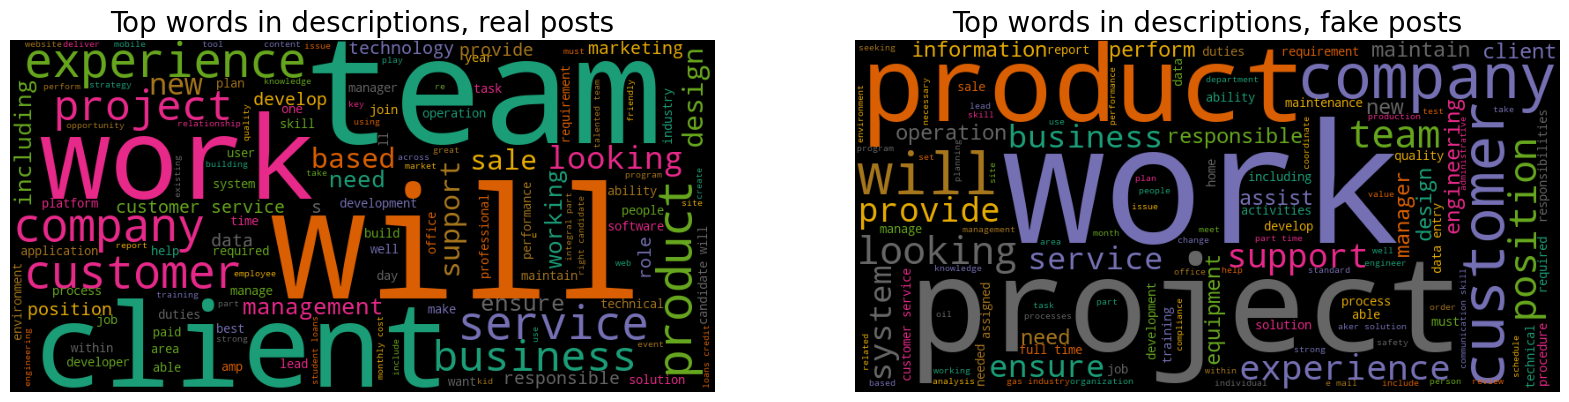

In [26]:
n_posts = 1000
real_desc = postings_new[postings_new['fraudulent'] == 0]['description'].fillna("").str.lower()
fake_desc = postings_new[postings_new['fraudulent'] == 1]['description'].fillna("").str.lower()
q_S = ' '.join(real_desc.values[:n_posts])
q_I = ' '.join(fake_desc.values[:n_posts])
wordcloud_S = WordCloud(max_font_size=None, scale=2, colormap='Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None, scale=2, colormap='Dark2').generate(q_I)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words in descriptions, real posts', fontsize=20)
ax[0].axis("off")
ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words in descriptions, fake posts', fontsize=20)
ax[1].axis("off")
plt.savefig("word_clouds.png", dpi=300, bbox_inches='tight')
plt.show()

Before we clean the job descriptions and apply TF-IDF vectorizer, we need to split the data into train, validation, and test subsets to prevent data leakage (if we fit TF-IDF vectorizer on the entire dataset, the information from the test subset will influence vectorization). Our dataset is imbalanced, so we apply stratified data split to preserve the same proportion of real/fake posts in each subset.

In [28]:
# First split will be 80% train, 20% (val + test)
train_df, temp_df = train_test_split(
    postings_new,
    test_size=0.2,
    stratify=postings_new["fraudulent"],
    random_state=42
)

# Second split will be 50% val, 50% test of the remaining 20% 
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["fraudulent"],
    random_state=42
)

print("Train class distribution:\n", train_df["fraudulent"].value_counts(normalize=True))
print("Validation class distribution:\n", val_df["fraudulent"].value_counts(normalize=True))
print("Test class distribution:\n", test_df["fraudulent"].value_counts(normalize=True))

Train class distribution:
 fraudulent
0    0.951552
1    0.048448
Name: proportion, dtype: float64
Validation class distribution:
 fraudulent
0    0.951342
1    0.048658
Name: proportion, dtype: float64
Test class distribution:
 fraudulent
0    0.951902
1    0.048098
Name: proportion, dtype: float64


### Text Cleaning and TF-IDF Vectorization

Data cleaning includes removing stop words, removing all punctuation except hyphens, stripping HTML tags if there are any, converting text to lowercase, removing extra whitespace, and applying lemmatization.

In [31]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# we customize stopword list 
keep_stopwords = {"full", "part", "no", "any"}
custom_stopwords = STOP_WORDS - keep_stopwords

def clean_and_lemmatize(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[-–—]{2,}", " ", text)
    text = re.sub(r"\s*-\s*", "-", text)
    text = re.sub(r"\b-\b", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation.replace('-', ''))}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    doc = nlp(text)
    lemmatized_text = " ".join([
        token.lemma_ for token in doc if token.text not in custom_stopwords
    ])
    return lemmatized_text

In [32]:
train_df["clean_description"] = train_df["description"].apply(clean_and_lemmatize)
val_df["clean_description"] = val_df["description"].apply(clean_and_lemmatize)
test_df["clean_description"] = test_df["description"].apply(clean_and_lemmatize)

We can compare job description before/after cleaning

In [34]:
train_df['description'][0]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [35]:
train_df['clean_description'][0]

'food52 fast grow james beard award win online food community crowd source curate recipe hub currently interview full part time unpaid intern work small team editor executive developer new york city headquartersreproduce andor repackage exist food52 content number partner site huffington post yahoo buzzfeed content management system research blog website provision food52 affiliate program assist day day affiliate program support screen affiliate assist any affiliate inquiry support pr event need help office administrative work filing mailing prepare meeting work developer document bug suggest improvement site support marketing executive staff'

Then we extract input features and target labels. 

In [37]:
X_train = train_df[["clean_description", "word_count"]]
y_train = train_df["fraudulent"]

X_val = val_df[["clean_description", "word_count"]]
y_val = val_df["fraudulent"]

X_test = test_df[["clean_description", "word_count"]]
y_test = test_df["fraudulent"]

scaler = MinMaxScaler()
train_df["word_count"] = scaler.fit_transform(train_df[["word_count"]])
val_df["word_count"] = scaler.transform(val_df[["word_count"]])
test_df["word_count"] = scaler.transform(test_df[["word_count"]])

print("Data distribution:\n- Train: {} Validation: {} Test: {}".format(len(y_train), len(y_val), len(y_test)))

Data distribution:
- Train: 14304 Validation: 1788 Test: 1788


In [38]:
X_train.head()

,clean_description,word_count
7530,tidewater finance company locate virginia beac...,234
129,customer service associate base dallas tx righ...,262
4640,look dedicated passionate software test analys...,192
402,sale representative provide assistance custome...,177
13218,undie lifestyle brand transform way people per...,224


TF-IDF (Term Frequency–Inverse Document Frequency) vectorization transforms text into numerical features by quantifying how important a word is in a document relative to the entire corpus (collection of text documents). We apply vectorizer which limits vocabulary to top 5000 mst important terms, ignores words that appear in fewer than 5 documents, includes 1 and 2-words phrases.

In [40]:
train_df["clean_description"] = train_df["clean_description"].fillna("")
val_df["clean_description"] = val_df["clean_description"].fillna("")
test_df["clean_description"] = test_df["clean_description"].fillna("")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    ngram_range=(1, 2)
)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["clean_description"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["clean_description"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_description"])
X_train_tfidf_df = pd.DataFrame(
    X_train_tfidf[:5].toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

X_train_tfidf_df.head()

,aan,ab,abc,abc supply,ability,ability build,ability communicate,ability demonstrate,ability effectively,ability manage,...,york ny,young,young people,youth,youwe,youyou,zealand,zero,zijn,zone
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.057169,0.0,0.106906,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.220164,0.112017,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["clean_description"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["clean_description"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_description"])
word_count_train = csr_matrix(train_df["word_count"].values.reshape(-1, 1))
word_count_val = csr_matrix(val_df["word_count"].values.reshape(-1, 1))
word_count_test = csr_matrix(test_df["word_count"].values.reshape(-1, 1))

X_train_combined = hstack([X_train_tfidf, word_count_train])
X_val_combined = hstack([X_val_tfidf, word_count_val])
X_test_combined = hstack([X_test_tfidf, word_count_test])

## Models

To make the project more representative and robust, we built three models: Logistic Regression, Linear SVM, and XGBoost. It is standard practice in data science to evaluate multiple models before making a final selection. The choice of models was deliberate: 
- Logistic Regression provides an interpretable baseline
- SVM focuses on margin maximization for better class separation
- XGBoost is a tree-based ensemble method capable of capturing complex patterns.

Comparing these models allows us to validate performance consistency, explore different algorithmic perspectives, and ultimately select the most suitable model for the task.

### Logistic Regression 

Logistic regression is often used as a baseline model for classification tasks. It is simple, fast, and offers strong performance with sparse feature matrices. To find the best combination of hyperparameters, we use randomized search. Additionally, we apply a class weighting scheme (class_weight="balanced") to penalize the model more heavily for misclassifying class 1 (fake postings). This approach increases recall, which measures how many actual fake postings are correctly identified. Prioritizing recall helps minimize the number of missed fake jobs, which may otherwise expose users to scams or phishing. So, optimizing for recall contributes to user protection and platform safety.

In [46]:
log_reg_m = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
param_dist = {
    "C": np.logspace(-3, 2, 10)}
random_search = RandomizedSearchCV(
    log_reg_m,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    scoring="recall",
    verbose=1,
    n_jobs=-1,
    random_state=42)
random_search.fit(X_train_combined, y_train)
best_log_reg_m = random_search.best_estimator_
print(f"Best regularization parameter (C): {random_search.best_params_['C']}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best regularization parameter (C): 0.5994842503189409


In [47]:
y_train_log_m = best_log_reg_m.predict(X_train_combined)
y_val_log_m = best_log_reg_m.predict(X_val_combined)
y_test_log_m = best_log_reg_m.predict(X_test_combined)

### Linear Regression Evaluation

Both validation and test results are evaluated using standard metrics: accuracy, precision, recall, and F1 score. The validation set is used during training for hyperparameter tuning, the test set represents completely unseen data. By comparing validation and test results, we can assess how well the model generalizes and whether it is overfitting. In this case, the model performs very well: all metrics are high, and both accuracy and recall are slightly higher on the test set, while precision remains comparable or better. This consistency across datasets indicates that the model generalizes well and shows no signs of overfitting.

In [50]:
print("\n Validation Set Classification Report:")
print(classification_report(y_val, y_val_log_m))

print("\n Test Set Classification Report:")
print(classification_report(y_test, y_test_log_m))


 Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1701
           1       0.43      0.80      0.56        87

    accuracy                           0.94      1788
   macro avg       0.71      0.87      0.76      1788
weighted avg       0.96      0.94      0.95      1788


 Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1702
           1       0.47      0.84      0.60        86

    accuracy                           0.95      1788
   macro avg       0.73      0.89      0.79      1788
weighted avg       0.97      0.95      0.95      1788



It is also useful to build a confusion matrix which shows actual counts of true positive, false positive, true negative, false negative. The model correctly identified 72 false postings (TP) but mistakenly identified 14 fake postings as real (FN). recall = TP / (TP + FN) = 72 / (72 + 14) = 0.837 It's a strong result for a fraud detection problem.  

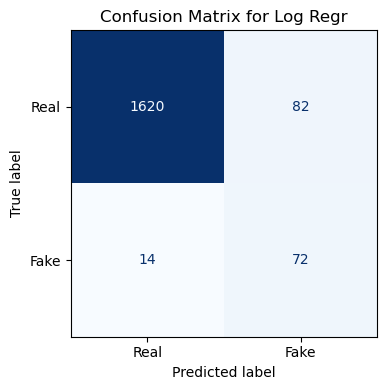

In [52]:
cm_lr = confusion_matrix(y_test, y_test_log_m)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues", ax=ax,  colorbar=False) 

plt.title("Confusion Matrix for Log Regr")
plt.tight_layout()
plt.savefig("conf_matrix_lr.png", dpi=300, bbox_inches='tight')
plt.show()

The precision-recall curve shows model behavior across all thresholds. It helps to tune the thresholds and compare model stability. Average Precision (AP) scores help to compare the model preformance. Here, the validation and test AP scores are very close, indicating strong generalization and no overfitting.

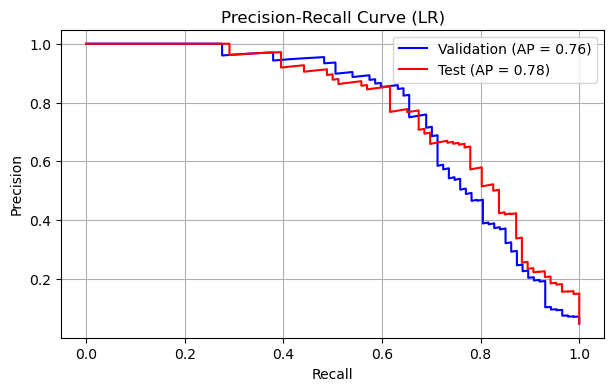

In [54]:
y_val_probs = best_log_reg_m.predict_proba(X_val_combined)[:, 1]
y_test_probs = best_log_reg_m.predict_proba(X_test_combined)[:, 1]
prec_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
prec_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)
avg_prec_val = average_precision_score(y_val, y_val_probs)
avg_prec_test = average_precision_score(y_test, y_test_probs)

plt.figure(figsize=(7, 4))
plt.plot(recall_val, prec_val, label=f"Validation (AP = {avg_prec_val:.2f})", color="blue")
plt.plot(recall_test, prec_test, label=f"Test (AP = {avg_prec_test:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LR)")
plt.legend()
plt.grid(True)
plt.savefig("prec_recall_lr.png", dpi=300, bbox_inches='tight')
plt.show()

### Linear Regression Explanation

In this part, we will try to find out which features are the most influential and impact the model's decision. For this purpose, we build a plot with shap values. Shap values in the case with logistic regression are expressed in log-odds units (logistic regression predicts log-odds, not probabilities directly, and SHAP values here represent the change in log-odds caused by each feature). In the plot below, each dot represents a feature in one of the samples in the test set. The x-axis shows how much that feature pushed the prediction toward class 0 ("Real") or class 1 ("Fake"). The color shows the feature value for that sample (red = high, blue = low). The SHAP summary plot shows that features such as “team”, “client”, “web”, "user", "marketing", "word_count" are among the most impactful. When these words are present in a job ad (high TF-IDF), they have a strong negative SHAP value. It means they push the model toward predicting “real.” Conversely, their absence leads to small positive SHAP values, nudging predictions toward “Fake.”

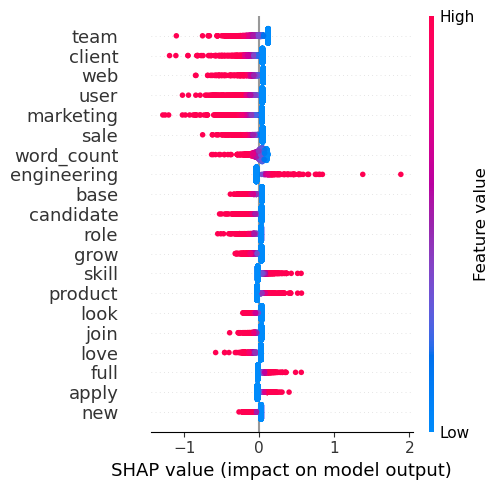

In [57]:
X_train_dense = X_train_combined.toarray()
X_test_dense = X_test_combined.toarray()
tfidf_features = tfidf_vectorizer.get_feature_names_out()
full_feature_names = list(tfidf_features) + ["word_count"]

masker = Independent(X_train_dense)
explainer = shap.Explainer(best_log_reg_m, masker, feature_names=full_feature_names)
shap_values = explainer(X_test_dense)
shap.summary_plot(
    shap_values.values,
    X_test_dense,
    feature_names=full_feature_names,
    plot_size=(5, 5),  # controls width, height in inches
    show=True
)

shap.plots.beeswarm(shap_values, max_display=20, show=False)

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig("shap_lr.png", dpi=300, bbox_inches='tight')
plt.close()

Now let us pick one sample. We see the description, words count, we see that it is a real job postings. The model classifies it as a real job posting. 

In [59]:
sample_idx = min(10, X_test_dense.shape[0] - 1)
original_job_posting = test_df.iloc[sample_idx]
print("---Cleaned Description:--- ")
print(original_job_posting["clean_description"])
print("\n---Word Count--- ")
print(original_job_posting["word_count"])
print("\n ---Full Row--- ")
print(original_job_posting)

---Cleaned Description:--- 
social wellth develop new industry lead m health app curation certification service m wellth ™ app certification m wellth app certification curate evaluate mobile web health app standpoint healthcare sponsor programmatic requirement address consumer ’ want need mhealth app potential demonstrate evidence engagement sustained usage clinical effectiveness candidate possess strong interest knowledge mobileweb digital health intervention abreast innovation new product rapidly evolve mhealth space relatively hand position work focused team product science engineering professional sustain expand socialwellth ' s emerge position digital health curation service position manage app curation lifecycle include build pipeline digital asset recommendation healthcare sponsor position act primary customersponsor face liaison social wellth productscience team broad social wellth organization include limit strong collaborative interaction client service sale marketing role re

In [60]:
predicted_class = best_log_reg_m.predict(X_test_combined[sample_idx])[0]
print(f"Predicted class label: {predicted_class}")

Predicted class label: 0


Here we see the features that impacted the model's decision.

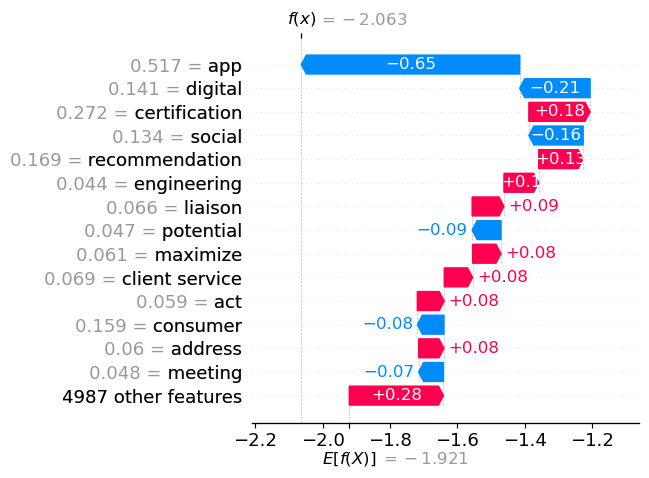

In [62]:
sample_idx = 10
shap.plots.waterfall(shap_values[sample_idx], max_display=15, show=False)
# Resize the current figure
plt.gcf().set_size_inches(5, 5)  
plt.show()

## Support Vector Machines (SVM)

The linear regression model performed very well. It is interesting to try other models as well. 

In [65]:
svm_m = LinearSVC(random_state=42, max_iter=5000, class_weight="balanced")
svm_m.fit(X_train_combined, y_train)

LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

### SVM Evaluation

The linear SVM model also demonstrates strong performance. It maintains high precision and recall for "Real" category and achieves 76–80% recall for the "fake" class. It achieves 96% accuracy on both the validation and test sets (though accuracy is not that important in this case). As the difference between validation and test subsets is very small, we can conclude that the model generalizes well and effectively handles class imbalance. 

In [68]:
y_val_svm = svm_m.predict(X_val_combined)
y_test_svm = svm_m.predict(X_test_combined)

print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_svm, target_names=["Real", "Fake"]))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_svm, target_names=["Real", "Fake"]))

Validation Set Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.97      0.98      1701
        Fake       0.61      0.76      0.67        87

    accuracy                           0.96      1788
   macro avg       0.80      0.87      0.83      1788
weighted avg       0.97      0.96      0.97      1788


Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.97      0.98      1702
        Fake       0.60      0.80      0.69        86

    accuracy                           0.96      1788
   macro avg       0.79      0.89      0.83      1788
weighted avg       0.97      0.96      0.97      1788



In the confusion matrix we can see that the model correctly identified 69 false postings (TP) but mistakenly identified 17 fake postings as real (FN). recall = TP / (TP + FN) = 69 / (69 + 17) = 0.8  

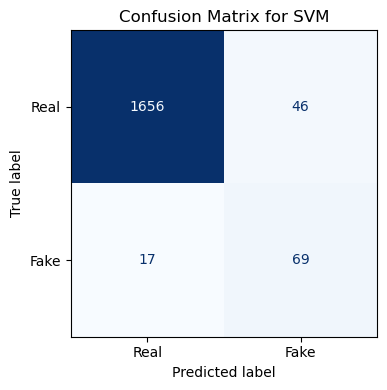

In [70]:
cm_svm = confusion_matrix(y_test, y_test_svm)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues", ax=ax,  colorbar=False) 

plt.title("Confusion Matrix for SVM")
plt.tight_layout()
plt.savefig("conf_matrix_svm.png", dpi=300, bbox_inches='tight')
plt.show()

The validation and test AP scores are very close, indicating strong generalization and no overfitting. The scores are higher than those of Logistic Regression model.

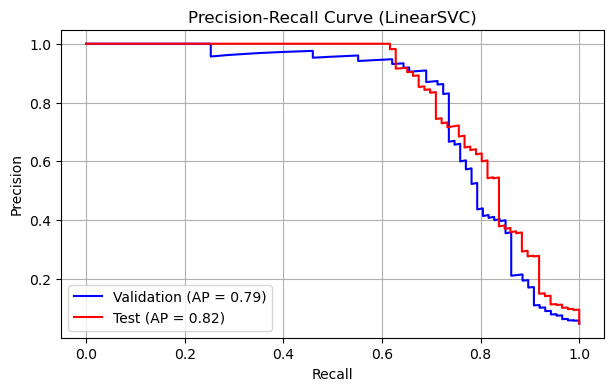

In [72]:
y_val_scores = svm_m.decision_function(X_val_combined)
y_test_scores = svm_m.decision_function(X_test_combined)
prec_val, recall_val, _ = precision_recall_curve(y_val, y_val_scores)
prec_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
avg_prec_val = average_precision_score(y_val, y_val_scores)
avg_prec_test = average_precision_score(y_test, y_test_scores)

plt.figure(figsize=(7, 4))
plt.plot(recall_val, prec_val, label=f"Validation (AP = {avg_prec_val:.2f})", color="blue")
plt.plot(recall_test, prec_test, label=f"Test (AP = {avg_prec_test:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LinearSVC)")
plt.legend()
plt.grid(True)
plt.savefig("prec_recall_svm.png", dpi=300, bbox_inches='tight')
plt.show()

### SVM Explanation

To understand how individual features contribute to the predictions made by the LinearSVC model, we build the SHAP summary plot again. SHAP values here are in units of the SVM margin, the distance from the separating hyperplane. Each point on the plot represents a single job posting and the impact of one feature on the model’s output for that sample. We can see the most important features on the Y axis. They are ranked by their average impact on the model across all validation samples. Importance here is defined as the mean absolute SHAP value, not by how large the feature value is. The X-axis shows the SHAP value. SHAP values quantify how much a feature pushes the model’s decision score toward predicting "Fake" (positive SHAP value) or "Real" (negative SHAP value). A SHAP value close to 0 means the feature has little effect on the prediction for that sample. The color of each point represents the original feature value for that observation:

- Red means the feature had a high value (high TF-IDF or long word_count)

- Blue means the feature had a low value (word absent/low frequency, or short word_count).

Important:

- SHAP value shows the effect a feature had on the prediction
  
- Feature value (color) shows the actual value of that feature in the sample

High feature value does not mean high impact. Some high values may have little or even opposite impact depending on context. For example, the plot may show that short descriptions (word_count low, in blue) push predictions toward the "Fake" class, while longer descriptions (red) reduce that probability, suggesting that legitimate job ads are more detailed. Similarly, certain keywords (like “remote,” “opportunity,” etc.) with high TF-IDF scores may consistently push the model toward predicting “Fake,” highlighting patterns the model has learned.

The SHAP summary plot shows that features such as “team,” “look,” and “user” are among the most impactful. When these words are present in a job ad (high TF-IDF), they have a strong negative SHAP value. It means they push the model toward predicting “real”. Conversely, their absence leads to small positive SHAP values, nudging predictions toward “Fake.” This pattern suggests that authentic job ads are more likely to use language that emphasizes the work environment and user interaction, while fake ads tend to omit such terms. As for word_count, the shap plot reveals that longer job descriptions (high word count, shown in red) push the model toward predicting “Fake”. Shorter descriptions (low word count, shown in blue) nudge the model slightly toward “real.” It looks somewhat counterintuitive: we usually expect shorter ads to be suspicious/fake. However, the model learned the opposite. At least in this dataset fake job ads tend to be unusually long. 

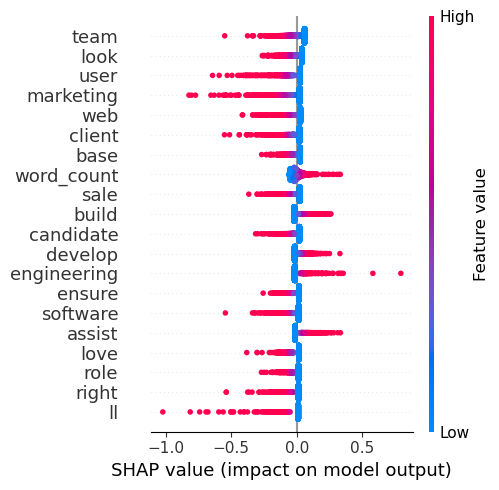

In [75]:
svm_m = LinearSVC(random_state=42, max_iter=20000, class_weight="balanced")
svm_m.fit(X_train_combined, y_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names = list(tfidf_feature_names) + ["word_count"]
explainer = shap.Explainer(svm_m, X_train_combined, feature_names=feature_names)
shap_values = explainer(X_test_combined)
X_test_dense = X_test_combined.toarray()
shap.summary_plot(shap_values.values, 
                  X_test_dense, 
                  feature_names=feature_names,
                  plot_size=(5, 5))
shap.plots.beeswarm(shap_values, max_display=20, show=False)

fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig("shap_svm.png", dpi=300, bbox_inches='tight')
plt.close()

If we return to the logistic regression model, we will see that word_count pushed predictions toward "fake" category. Probably, it is worth to take a look at the coefficients. We appended word_count as the last feature. Its coefficient:

- Logistic Regression -1.3476

- Linear SVM +0.7009

In [77]:
# logistic regression
print(best_log_reg_m.coef_)

# linear SVM
print(svm_m.coef_)

[[-0.16588636 -0.16768423 -0.53756911 ... -0.13984386 -0.41659678
  -1.34762125]]
[[-0.10769451  0.02959637 -0.65693469 ... -0.00433175 -0.58105248
   0.70097761]]


This case with word_count proves that different models capture different patterns in the same data. The model selection depends on the model's performance and our domain knowledge. Here the models' results are comparable. So, we need to answer the question: "Are longer job ads generally more trustworthy?" The answer will help to select the model (given the evaluation results of the models are similar). 

## XGBoost

In this part of the project we build a XGBoost model. RandomizedSearch helps to select the best parameters

In [81]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
scale_pos_weight = weights[0] / weights[1]
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight  # handle imbalance
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=8,  
    scoring="recall",  
    cv=3,              
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_combined, y_train)
best_xgb = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


Although the XGBoost model was tuned for recall, it still demonstrates high precision but poor recall for the minority class. It means that while predictions of fake posts are accurate, the model fails to identify the majority of them. We can lower the threshold to address this issue (the current threshold is 0.5 by default). However, it doesn't make sense since the logistic regression and SVM already achieved strong performance.

In [83]:
best_xgb = random_search.best_estimator_

y_val_pred = best_xgb.predict(X_val_combined)
y_test_pred = best_xgb.predict(X_test_combined)

print("Validation Set Report:")
print(classification_report(y_val, y_val_pred))
print("Test Set Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1701
           1       0.96      0.29      0.44        87

    accuracy                           0.96      1788
   macro avg       0.96      0.64      0.71      1788
weighted avg       0.96      0.96      0.96      1788

Test Set Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1702
           1       1.00      0.26      0.41        86

    accuracy                           0.96      1788
   macro avg       0.98      0.63      0.69      1788
weighted avg       0.97      0.96      0.95      1788



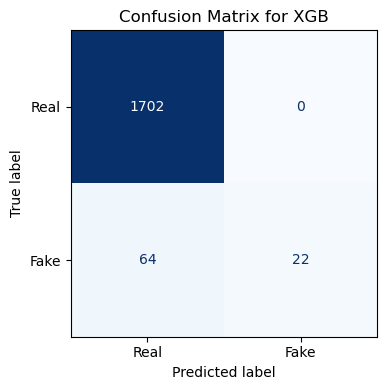

In [84]:
cm_xgb = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues", ax=ax, colorbar=False) 

plt.title("Confusion Matrix for XGB")
plt.tight_layout()
plt.savefig("conf_matrix_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

Validation AP=0.72. It is driven primarily by high precision since recall is very low. The drop to AP=0.67 for the test dataset is moderate and suggests that generalization is not great.

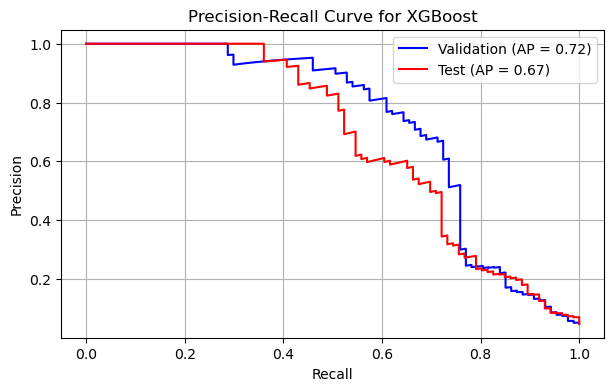

In [86]:
y_val_probs = best_xgb.predict_proba(X_val_combined)[:, 1]
y_test_probs = best_xgb.predict_proba(X_test_combined)[:, 1]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_probs)
avg_precision_val = average_precision_score(y_val, y_val_probs)
avg_precision_test = average_precision_score(y_test, y_test_probs)
plt.figure(figsize=(7, 4))
plt.plot(recall_val, precision_val, label=f"Validation (AP = {avg_precision_val:.2f})", color="blue")
plt.plot(recall_test, precision_test, label=f"Test (AP = {avg_precision_test:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for XGBoost")
plt.legend()
plt.grid(True)
plt.savefig("prec_recall_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

# Conclusion

<div style="border-radius: 15px; box-shadow: 4px 4px 12px rgba(0,0,0,0.2); border: solid green 2px; padding: 20px; font-family: Arial, sans-serif; font-size: 15px; background-color: #f9fff9;">
<b>This project explored the challenge of classifying job postings as real or fake</b> using natural language processing and machine learning techniques. By combining text-based features (TF-IDF, word count) with structured metadata, we developed models that help identify potentially fraudulent listings.<br><br>

We trained and evaluated three models — <b>Logistic Regression</b>, <b>SVM</b>, and <b>XGBoost</b> — with a strong focus on <b>recall</b>, given the importance of detecting fake postings to protect users. After extensive tuning and performance comparison, <b>Logistic Regression</b> was selected as the final model due to its strong recall, consistent generalization, and interpretability.<br><br>

✅ <b>Answers to Research Questions</b><br><br>

<b>Can we accurately classify job postings as real or fake?</b><br>
Yes. All three models achieved high classification performance, with accuracies near or above 96% and solid recall for the fake class — the most challenging target.<br><br>

<b>What patterns and features differentiate fake from real job posts?</b><br>
Real postings tend to be longer and use more specific job-related language. In contrast, fake postings often use vague or overly generic terms like “opportunity” or “hiring.” EDA and SHAP analysis revealed that certain words and the overall length of the post are strong indicators of authenticity.<br><br>

<b>How do the models make their predictions?</b><br>
Using SHAP explainability, we visualized how individual features influenced predictions. The most impactful features included keywords like “team,” “client,” and “user,” as well as <code>word_count</code>. The models learned different patterns from the same data — highlighting the importance of aligning model behavior with domain knowledge when making a final selection.
</div>